# Домашнее задание "Обучение сверточной сети на практике" по модулю "Компьютерное зрение"

Задание: Првести классификацию изображений на датасете Cats vs Dogs
Обучить модель классификации изображений на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.


Ссылка на шаблон ноутбука и датасет https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

## Библиотеки

In [1]:
import cv2
import numpy as np
import tensorflow as tf

import keras
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.17.0
True


## Загрузка данных

In [2]:
import os
from random import shuffle
from glob import glob

In [3]:
# Подключение google диска

from google.colab import drive
drive.mount('/content/drive')

import zipfile

# Путь к zip архиву на яндекс диске
archive_path_train =  '/content/drive/MyDrive/Working_1/HW_2_comp_vision/train.zip'
archive_path_test =   '/content/drive/MyDrive/Working_1/HW_2_comp_vision/test.zip'

# Распаковываем zip архив
with zipfile.ZipFile(archive_path_train, 'r') as zip_ref_train:
    zip_ref_train.extractall()
    print('train данные успешно загружены')

with zipfile.ZipFile(archive_path_test, 'r') as zip_ref_test:
    zip_ref_test.extractall()
    print('test данные успешно загружены')

Mounted at /content/drive
train данные успешно загружены
test данные успешно загружены


In [4]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Working_1/HW_2_comp_vision/sample_submission.csv')

df.label.value_counts()

,count
label,
0.5,12500


In [5]:
# записываем в переменные train_files, test_files файлы картинок

# импортируем модуль os
import os

# выводим пути к папкам (dirpath) и наименования файлов (filenames)

# train
for dirpath, _, filenames_train in os.walk('/content/train'):

  train_files = []
  # во вложенном цикле проходимся по названиям файлов и записываем полный путь
  for filename in filenames_train:

    train_files.append(os.path.join(dirpath, filename))

# test
for dirpath, _, filenames_test in os.walk('/content/test'):

  test_files = []
  # во вложенном цикле проходимся по названиям файлов и записываем полный путь
  for filename in filenames_test:

    test_files.append(os.path.join(dirpath, filename))



In [6]:
# Размеры выборок
len(train_files), len(test_files),

(25000, 12500)

In [7]:
# в файлах полный путь к картинке
test_files[10], train_files[15]

('/content/test/7788.jpg', '/content/train/cat.2119.jpg')

In [8]:
# Функции считывания изображений для подачи в нейросеть

IMG_SIZE = (224, 224)  # размер входного изображения сети


# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield (np.array([load_image(path)]),)

## Визуализируем примеры для обучения

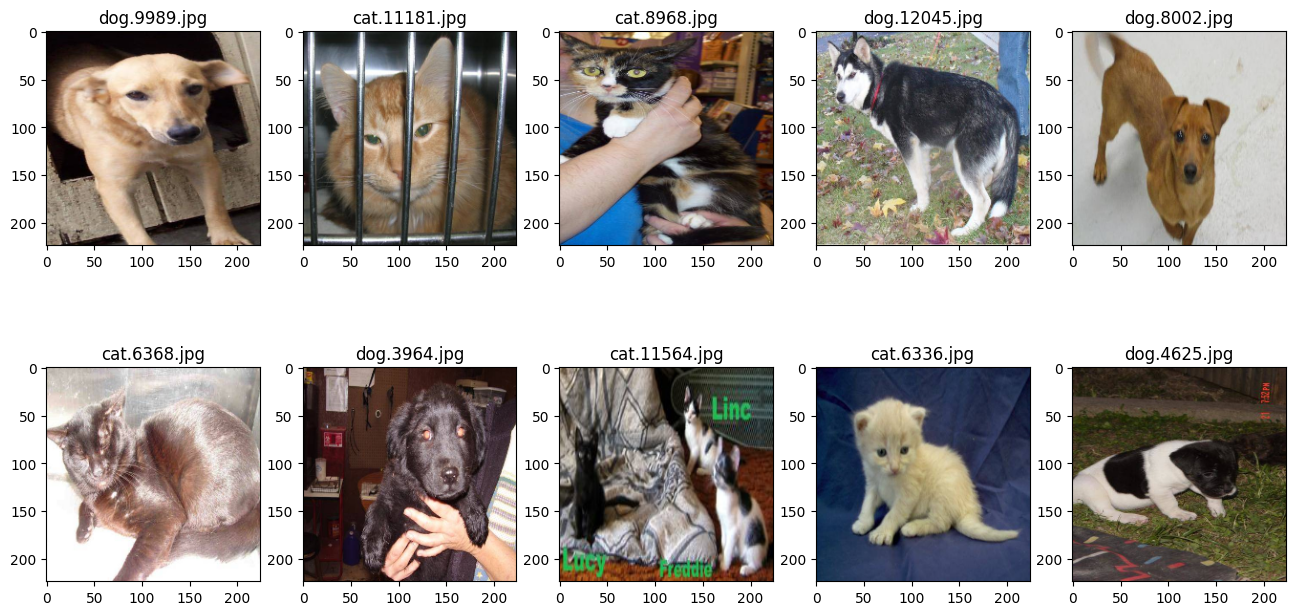

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель VGG16

In [9]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Добавляем слой GlobalAveragePooling2D вместо Flatten

In [11]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

Дополнение в базовую архитектуру:
1. слой GlobalAveragePooling2D
2. слой Dropout(0.2) (выключаем 20% от 512 нейронов)
3. полносвязный слой 32 нейрона
4. полносвязный слой для вывода вероятности принадлежности к классу

## Выводим архитектуру модели

In [12]:
model.summary()

Model: "dogs_vs_cats"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,651,713 (29.19 MB)

 Trainable params: 16,449 (64.25 KB)

 Non-trainable params: 7,635,264 (29.13 MB)

## Компилируем модель и запускаем обучение

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [14]:
# cuda - видеокарта

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
# Модель (5000 картинок на валидацию, 20000 на обучение), checkpoint по min val_loss
val_samples = 5000  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку

validation_data = next(fit_generator(train_files[:val_samples], batch_size = 32))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# Checkpoint

from pathlib import Path
path = Path("/content/drive/MyDrive/Working_1/HW_2_comp_vision/dogs_vs_cats")
path.mkdir(exist_ok=True) # создаем папку

cpt_filename = "{epoch:02d}_chp_train_5000val_acc_{val_accuracy}_loss_{val_loss:.6f}.keras"
cpt_path = str(path / cpt_filename)

# запускаем процесс обучения

model.fit(train_data,
          steps_per_epoch=5,  # число вызовов генератора за эпоху
          epochs=1000,  # число эпох обучения
          validation_data=validation_data,
          callbacks=[
              tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min'),\
              tf.keras.callbacks.EarlyStopping(patience=50)])

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5003 - loss: 19.5325
Epoch 1: val_loss improved from inf to 12.72023, saving model to /content/drive/MyDrive/Working_1/HW_2_comp_vision/dogs_vs_cats/01_chp_train_5000val_acc_0.5_loss_12.720226.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 777ms/step - accuracy: 0.5044 - loss: 19.2340 - val_accuracy: 0.5000 - val_loss: 12.7202
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5741 - loss: 13.7444
Epoch 2: val_loss did not improve from 12.72023
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.5753 - loss: 13.6855 - val_accuracy: 0.5312 - val_loss: 18.9736
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6424 - loss: 14.3089
Epoch 3: val_loss improved from 12.72023 to 7.35300, saving model to /content/drive/MyDrive/Working_1/HW_2_comp_vision/dogs_vs_cats/03_chp_train_5000val_acc_0.59375_loss_7.352998.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.6510 - loss: 13.7434 - val_accuracy: 0.5

In [16]:
!ls "/content/drive/MyDrive/Working_1/HW_2_comp_vision/dogs_vs_cats/"

01_chp_train_5000val_acc_0.5_loss_12.720226.keras
03_chp_train_5000val_acc_0.59375_loss_7.352998.keras
05_10_1_checkpoints
05_chp_train_5000val_acc_0.78125_loss_4.245296.keras
06_chp_train_5000val_acc_0.8125_loss_2.781775.keras
133_chp_train_5000val_acc_0.90625_loss_0.388922.keras
134_chp_train_5000val_acc_0.9375_loss_0.370129.keras
137_chp_train_5000val_acc_0.9375_loss_0.348174.keras
138_chp_train_5000val_acc_0.90625_loss_0.344035.keras
147_chp_train_5000val_acc_0.90625_loss_0.342768.keras
148_chp_train_5000val_acc_0.90625_loss_0.334999.keras
158_chp_train_5000val_acc_0.90625_loss_0.327070.keras
161_chp_train_5000val_acc_0.9375_loss_0.320513.keras
162_chp_train_5000val_acc_0.9375_loss_0.314740.keras
164_chp_train_5000val_acc_0.90625_loss_0.314408.keras
166_chp_train_5000val_acc_0.90625_loss_0.300370.keras
168_chp_train_5000val_acc_0.90625_loss_0.288484.keras
169_chp_train_5000val_acc_0.90625_loss_0.285836.keras
16_chp_train_5000val_acc_0.90625_loss_2.158071.keras
170_chp_train_5000val

Выбираем в качестве лучшей модели последнюю по checkpoint

## Предсказания на проверочной выборке

In [17]:
model_best = tf.keras.models.load_model("/content/drive/MyDrive/Working_1/HW_2_comp_vision/dogs_vs_cats/285_chp_train_5000val_acc_0.9375_loss_0.174405.keras")

test_pred = model_best.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 90s 7ms/step


In [18]:
test_pred, len(test_pred)

(array([[0.9921084 ],
        [0.0524632 ],
        [0.99868673],
        ...,
        [0.06364515],
        [0.00732562],
        [0.9406377 ]], dtype=float32),
 12500)

<ipython-input-26-fb6ddecd4396>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


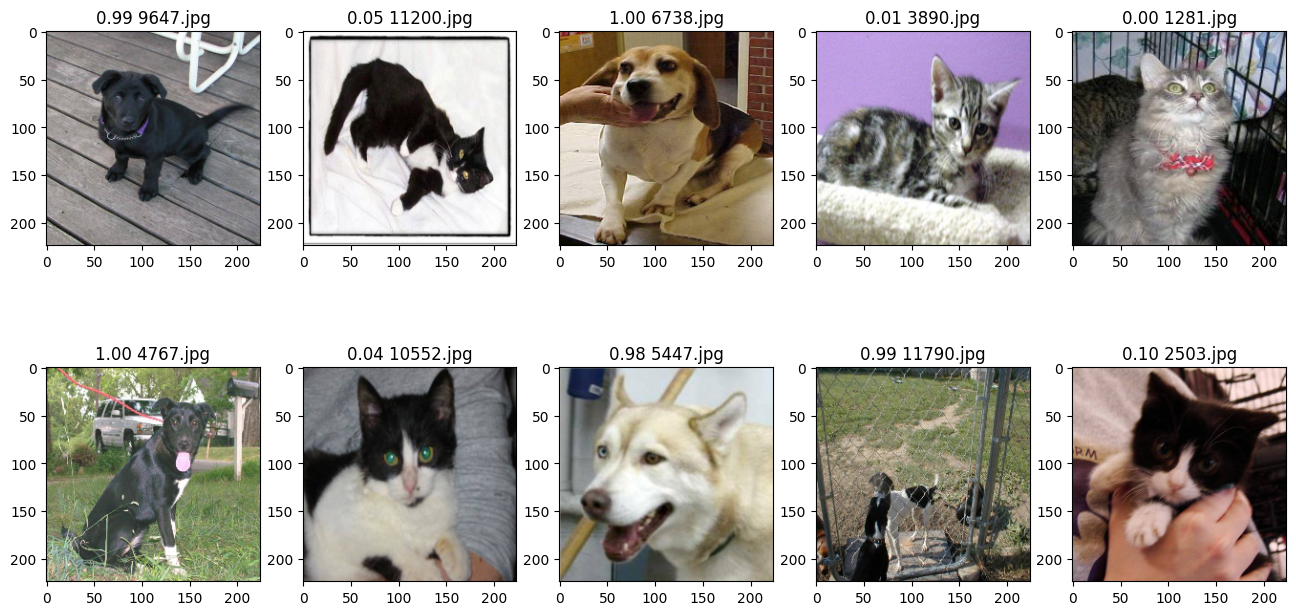

In [26]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [19]:
import re

result_df = pd.DataFrame(columns=['id', 'label'])

with open('dogs_vs_cats_test_pred.txt', 'w') as dst:
    dst.write('id,label\n')

    for i, (path, score) in enumerate(zip(test_files, test_pred)):

          file_id = int(re.search('(\d+).jpg$', path).group(1))
          file_score = float(score[0])

          dst.write('%s,%f\n' % (file_id, file_score))

          result_df.loc[len(result_df)] = [file_id, file_score]


In [20]:
result_df.id = result_df.id.astype(int)


In [21]:
result_df.head()

,id,label
0,9647,0.992108
1,11200,0.052463
2,6738,0.998687
3,3890,0.013289
4,1281,0.004118


In [22]:
result_df_v2 = result_df.sort_values(by='id')
result_df_v3 = result_df_v2.set_index('id')
result_df_v3.head()

,label
id,
1,0.996369
2,0.997185
3,0.956788
4,0.999780
5,0.030970


In [23]:
result_df_v3.to_csv('sample_submission_05_10_v3_285ep.csv')

In [ ]:
# Проверка на Kaggle на тестовой выборке: LogLoss = 0.16486

## Итоги:
1. Для решения задачи бинарной классификации на датасете dogs_vs_cats использовалась предобученная модель VGG16
2. Были взяты все слои VGG16, кроме последних.
3. К выходам усеченной VGG16 добавлен слой GlobalAveragePooling, суммирующий данные по картам признаков (всего 512 карт)
4. Чтобы модель не переобучалась добавлен слой dropout (20% нейронов)
5. добавлен промежуточный полносвязный слой в 32 нейрона для постепенного уменьшения размерности
6. выходной слой - 1 нейрон с функцией активации sigmoid

7. Обучение проводилось при размере батча 32, на 1000 эпохах с параметром pations = 50 (количество эпох для улучшения после обновления оптимума)

8. Полученная модель показала точность 0.16 (<0.3 для зачета) на тестовых данных при проверке на Kaggle